In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid

In this final Notebook, we wish to evaluate three different models : A ridge regression, a $k$-NN and a $k$-mean algorithm. 

For the first two models, we will define our baseline as the median of the observations and we will use the MAE score as a comparition criterion. Firstly, we will see that both algorithms do not improve the naive model and we think that it could be due to the difficulty to understand the oscillatory behaviour of $\Delta$T over a too short period of time. That is why we will consider in a second step an averaged version of `df`.

# The regression part

In this first part, we build a machine learning model based on a ridge regression with a tuning process on the complexity $\alpha$ (the parameter of the ridge regression). We will use the data set containing the extra features we added in the first Notebook DataPreparation.ipynb.

In [6]:
## Download the data
df = pd.read_csv('data_extra_ML.csv')
## Print the top five entries
df.head()

,dt,Latitude,Longitude,Month,Year,Distance to ocean,CO2,cumul(CO2),Altitude,City,Country,Continent,$\Delta$T,log(Altitude),log(cumul(CO2)),log(Distance to ocean),CO2 small
0,1801-01-01,50.63,6.34,1.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,1.581,5.313206,1.40824,11.997598,1
1,1801-02-01,50.63,6.34,2.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,1.909,5.313206,1.40824,11.997598,1
2,1801-04-01,50.63,6.34,4.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,-3.166,5.313206,1.40824,11.997598,1
3,1801-05-01,50.63,6.34,5.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,-1.270,5.313206,1.40824,11.997598,1
4,1801-06-01,50.63,6.34,6.0,1801.0,162610.022319,0.0,0.0,177.0,Aachen,Germany,Europe,0.717,5.313206,1.40824,11.997598,1


We start by defining a function that returns the variables in the correct form. We decide to add a degree parameter which stands for the degree of the polynomial transformation we wish to apply.

In [7]:
## Function returning the variables
###################################
def get_variables(df,col_to_use,poly_cols,encoding_cols,test_size,deg,
                 random_state):
    ## Work on a copy of df
    df = df.copy()
    ## The target variable
    y = df['$\Delta$T']
    ## Select the columns we want to use for the model
    df = df[col_to_use]
    ## One-hot encoding process 
    df = pd.get_dummies(df,columns=encoding_cols) 
    ## Polynomial transformation
    pf_obj = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = pf_obj.fit_transform(df[poly_cols])
    X_others = df.drop(poly_cols,axis=1).values
    ## Get the complete X 
    X = np.c_[X_poly,X_others]
    ## Split X/y into train/test
    if test_size==0:
        X_train,X_test, y_train,y_test = train_test_split(X,y,shuffle=False,
                        random_state=random_state,test_size=test_size)
        return X_train,X_test,y_train,y_test 
    else:
        X_train,X_test, y_train,y_test = train_test_split(X,y,shuffle=True,
                        random_state=random_state,test_size=test_size)
        return  X_train,X_test,y_train,y_test        

In [8]:
## The columns to use
col_to_use = ['Latitude', 'Longitude', 'Month', 'Year',
            'log(Distance to ocean)','log(cumul(CO2))','log(Altitude)',
              'CO2 small']
## The columns to apply polynomial transformation
poly_cols = ['Latitude', 'Longitude','Year','log(Distance to ocean)',
             'log(cumul(CO2))','log(Altitude)']
## The columns to apply one-hot encoding
encoding_cols = ['Month']

## Get the variables with degree 2
X_train,X_test,y_train,y_test = get_variables(df,col_to_use=col_to_use,
    poly_cols=poly_cols,encoding_cols=encoding_cols,test_size=0.4,deg=2,
                                             random_state=0)

## Print the shape
print('X_train : {}, y_train : {}'.format(X_train.shape,y_train.shape))
print('X_test : {}, y_test : {}'.format(X_test.shape,y_test.shape))

X_train : (1356931, 40), y_train : (1356931,)
X_test : (904621, 40), y_test : (904621,)


We define now our baseline model. Since we decided to use the MAE score as a metric to compare our models, the median of the observations is a good choice.

In [9]:
## The baseline model
#####################
baseline = y_train.median()

## The MAE score
mae_baseline_complex = MAE(y_test,[baseline]*len(y_test))

## Print the results
print('MAE for the baseline model : {:.3f}'.format(
                                                    mae_baseline_complex))

MAE for the baseline model : 1.070


In [10]:
## Pipeline object
pipe_ridge = Pipeline([
    ('scaler',StandardScaler()),
    ('ridge',Ridge())
])
## Its grid of parameters
grid_ridge = ParameterGrid({
    'ridge__alpha': np.logspace(-2,4,num=20)
})

In [11]:
## Fit the models and print the results
#######################################

## Store the results
gs_results = []

## Grid search
for param_dict in grid_ridge:
    ## Assign the current parameters
    pipe_ridge.set_params(**param_dict)
    ## Fit the ridge regression
    pipe_ridge.fit(X_train,y_train)
    ## Compute preductions
    y_train_pred = pipe_ridge.predict(X_train) 
    y_test_pred = pipe_ridge.predict(X_test)
    ## Compute MAE scores 
    mae_test = MAE(y_test,y_test_pred)
    mae_train = MAE(y_train,y_train_pred)
    ## Add to the dictionnary
    param_dict['MAE test'] = mae_test
    param_dict['MAE train'] = mae_train
    ## Save the results
    gs_results.append(param_dict)

## Print the results
result_ridge_df = pd.DataFrame(gs_results).sort_values('MAE test')
result_ridge_df.head()

,MAE test,MAE train,ridge__alpha
10,1.070136,1.070665,14.384499
11,1.070137,1.070666,29.763514
9,1.070137,1.070665,6.951928
12,1.070137,1.070666,61.584821
8,1.070138,1.070665,3.359818


We also want to build a $k$-NN model. Since this is computationally expensive, we avoid the tuning step and we assign $5$ for the number of neighbors. 

In [12]:
## Pipeline object
pipe_knn = Pipeline([
    ('scaler',StandardScaler()),
    ('knn',KNeighborsRegressor(n_neighbors=5))
])

In [13]:
## Fit the model
pipe_knn.fit(X_train,y_train)
## Compute the MAE score
y_pred_test = pipe_knn.predict(X_test)
mae_knn = MAE(y_test,y_pred_test)
print('MAE score for the k-NN model : {:.3f}'.format(mae_knn))

MAE score for the k-NN model : 1.175


We are a bit disappointed because we observe that the two models do not improve the simplest model consisting in taking the median value and the $k$-NN model is even worst! We think that the main reason for that could be that the model has difficulties to understand the strong oscillations occuring in a short period of time. 

In fact, it is not very surprising that climate predictions fail to be precise if the unit of the time variable $t$ is one year. We should probably choose the unit of $t$ to be $25$ years, as in DataAnalysis.ipynb where we were able to distinguish some patterns, and thus average in consequence. 

We will thus replace `df` by its $25$ years average version and will evaluate a ridge regression and a $k$-NN model on it to see if we can improve on the baseline model.

## The averaged model 

In [14]:
## Average over 25 years
########################
## The list of cities
cities_list = df.City.value_counts().index
## The list of months
months_list = np.arange(1,13)
## All years appearing in the data
years = np.arange(1800,2001,25)
## Create the new DataFrame
DataFrames = []
for year in years:
    ## Filter df
    cond = (df.Year>=year+1) & (df.Year<=year+25)
    ## Group by city and month and compute the mean
    df_filter = df[cond].groupby(['City','Month']).mean()
    df_filter = df_filter.reset_index()
    df_filter['Year'] = year+1
    DataFrames.append(df_filter)
df = (pd.concat(DataFrames)).sample(frac=1)
df.head()

,City,Month,Latitude,Longitude,Year,Distance to ocean,CO2,cumul(CO2),Altitude,$\Delta$T,log(Altitude),log(cumul(CO2)),log(Distance to ocean),CO2 small
3285,Faridabad,11.0,28.13,77.27,1876,777817.932033,0.610889,4.617306,198.0,0.067273,5.411646,2.053160,13.563932,0.5
13913,Reading,6.0,50.63,-1.27,1976,4748.849263,214.109338,7352.692921,51.0,0.198167,4.343805,8.882035,8.412531,0.0
16027,Surgut,8.0,61.88,73.02,1951,407697.753509,449.380387,3226.386773,37.0,0.004733,4.143135,7.829115,12.917679,0.0
9321,Talara,11.0,-4.02,-81.16,1876,10420.761021,0.054594,0.321333,14.0,0.049600,3.688879,1.483163,9.227695,1.0
15224,Wellington,1.0,-40.99,174.67,1926,13156.126081,0.105670,0.123990,51.0,0.012240,4.343805,1.432642,9.465790,1.0


In [15]:
print('Lenght of the new df : ',len(df))

Lenght of the new df :  112784


This data set is of course smaller that the previous one and we recall that given $t$ in the year column, all associated quantities have to be understood has an averaging between $t$ and $t+25$. Let's evaluate the two previous model on this new data set.

In [16]:
## Get the new variables
########################
X_train,X_test,y_train,y_test = get_variables(df,col_to_use=col_to_use,
    poly_cols=poly_cols,encoding_cols=encoding_cols,test_size=0.4,deg=2,
                                             random_state=0)
## The baseline model
baseline = y_train.median()
mae_baseline = MAE(y_test,[baseline]*len(y_test))

In [17]:
print('MAE for the baseline model : {:.3f}'.format(mae_baseline))

MAE for the baseline model : 0.135


In [18]:
## The Ridge Regression
#######################
gs_results = []
for param_dict in grid_ridge:
    ## Assign the current parameters
    pipe_ridge.set_params(**param_dict)
    ## Fit the k-NN model
    pipe_ridge.fit(X_train,y_train)
    ## Compute preductions
    y_train_pred = pipe_ridge.predict(X_train) 
    y_test_pred = pipe_ridge.predict(X_test)
    ## Compute MAE scores 
    mae_test = MAE(y_test,y_test_pred)
    mae_train = MAE(y_train,y_train_pred)
    ## Add to the dictionnary
    param_dict['MAE test'] = mae_test
    param_dict['MAE train'] = mae_train
    ## Save the results
    gs_results.append(param_dict)

## Create the DataFrame
result_ridge_df = pd.DataFrame(gs_results).sort_values('MAE test',
                                                 ascending=True)

In [19]:
mae_ridge = result_ridge_df.iloc[0,0]
result_ridge_df.head()

,MAE test,MAE train,ridge__alpha
19,0.135423,0.138184,10000.000000
18,0.135533,0.138291,4832.930239
17,0.135598,0.138349,2335.721469
16,0.135641,0.138381,1128.837892
15,0.135696,0.138424,545.559478


In [20]:
## Try the k-NN model
#####################
pipe_knn.fit(X_train,y_train)
y_pred_test = pipe_knn.predict(X_test)
## Store the MAE score
mae_knn_5 = MAE(y_test,y_pred_test)
print('MAE score for the k-NN model with 5 neighbors : {:.3f}'.format(
                                                                mae_knn_5))

MAE score for the k-NN model with 5 neighbors : 0.091


We are happy to notice that at least the $k$-NN model is better than the trivial model and is more appropriate than the ridge regression. It certainely has to do with the direct geometric interpretation of the coordinates variables. Nevertheless, the $k$-NN approach will certainly not work if we want to have a predictive model with respect to the $t$-variable. Indeed, the new $\Delta$T is computed by taking the mean of the previous values.

From now on, we can focus on this algorithm and try to improve the MAE score by looking for the best value of $k$, use a different rescaling step for the coordinates and try different degrees concerning the polynomial transformation. 

Finally, we are curious to know if the extra features really have an influence on the accuracy of the model.

In [21]:
## Tune the number of neighbors
###############################
## The grid of parameters
grid_knn = ParameterGrid({
    'knn__n_neighbors':np.arange(1,35,5)
})
## Grid serach
gs_results = []
for param_dict in grid_knn:
    ## Assign the current parameters
    pipe_knn.set_params(**param_dict)
    ## Fit the k-NN model
    pipe_knn.fit(X_train,y_train)
    ## Compute preductions
    y_train_pred = pipe_knn.predict(X_train) 
    y_test_pred = pipe_knn.predict(X_test)
    ## Compute MAE scores 
    mae_test = MAE(y_test,y_test_pred)
    mae_train = MAE(y_train,y_train_pred)
    ## Add to the dictionnary
    param_dict['MAE test'] = mae_test
    param_dict['MAE train'] = mae_train
    ## Save the results
    gs_results.append(param_dict)

## Create the DataFrame
result_knn_df = pd.DataFrame(gs_results).sort_values('knn__n_neighbors',
                                                 ascending=True)

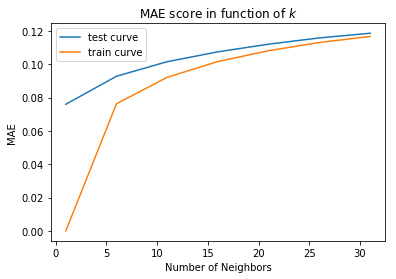

In [22]:
## Plot the results
###################
## The test curve
plt.plot(result_knn_df['knn__n_neighbors'].values,
                 result_knn_df['MAE test'].values,label='test curve')
## The train curve
plt.plot(result_knn_df['knn__n_neighbors'].values,
                     result_knn_df['MAE train'].values,label='train curve')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE')
plt.title('MAE score in function of $k$')
plt.legend()
plt.show()

In [23]:
## Store the best MAE score
mae_knn_1 = result_knn_df['MAE test'].values[0]
print('Best MAE test score with 1 neighbors : {:.4f}'.format(mae_knn_1))

Best MAE test score with 1 neighbors : 0.0760


Of course the train MAE score is zero for $k=1$ and it is not very surprising that the best test score is also obtained for $k=1$. We can imagine that taking the same annual temperature variation as the closest point is more precise than taking the mean value of the $k$ closest points for $k>1$. However, the choice of $k=5$ seems to be a good compromise to avoid overfitting.

Let's now explore the impact of the degree of the polynomial transformation on the test MAE score.

In [24]:
## Assign k = 5
pipe_knn.set_params(knn__n_neighbors=5);

In [25]:
## Tune the degree of the polynomial transformation
###################################################
mae_test_deg = []
for deg in np.arange(1,10):
    ## Get the variables
    X_train,X_test,y_train,y_test = get_variables(df,col_to_use=col_to_use,
    poly_cols=poly_cols,encoding_cols=encoding_cols,test_size=0.4,deg=deg,
                                                 random_state=0)
    ## Fit the k-NN model
    pipe_knn.fit(X_train,y_train)
    ## Compute preductions
    y_pred_test = pipe_knn.predict(X_test)
    ## Compute the MAE scores
    mae_knn_test = MAE(y_test,y_pred_test)
    mae_test_deg.append(mae_knn_test)

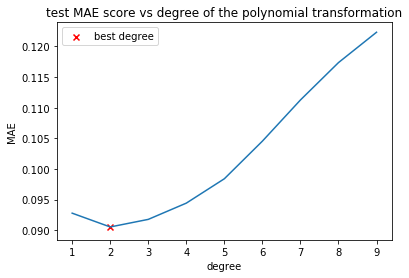

In [26]:
## Plot the results
###################
## The best degree value
best_degree = np.array(mae_test_deg).argmin()+1
## Th best mae score
best_mae = np.array(mae_test_deg).min()

#fig,axes = plt.subplots(1,1,figsize=(5,5))
plt.plot(np.arange(1,10),mae_test_deg)
plt.scatter(best_degree,best_mae,color='red',marker='x',label='best degree')
plt.xlabel('degree')
plt.ylabel('MAE')
#plt.ylim(0,0.03)
plt.title('test MAE score vs degree of the polynomial transformation')
plt.legend()
plt.show()

In [27]:
print('Best MAE score : {:.4f} for degree {}'.format(best_mae,best_degree))
print('MAE score with degree 1 : {:.4f}'.format(mae_test_deg[0]))

Best MAE score : 0.0905 for degree 2
MAE score with degree 1 : 0.0928


We see that we obtain the best result by taking degree $=2$ and that the model is clearly overfitting when the degree increases.

A last thing we can do is to use a different rescaling operation for the coordinates variables. Indeed, it is possible that the `StandardScaler()` causes distortions that may not be optimal. Since features need to have the same scale so that the models perform well, we can standardize the coordinates using the mean of the jointed Latitude/Longitude and similarly for the standard deviation. In this way, the Lat/Long have different scales but they are overall standardized. In order to avoid technical difficulties, we can evaluate it on a degree one polynomial transformation. 

In [28]:
col_to_use = ['Latitude','Longitude','Month', 'Year',
            'log(Distance to ocean)','log(cumul(CO2))','log(Altitude)',
             'CO2 small']
y = df['$\Delta$T'].values
df_test = df[col_to_use]
df_test = pd.get_dummies(df_test,columns=['Month'])
df_test.head()

,Latitude,Longitude,Year,log(Distance to ocean),log(cumul(CO2)),log(Altitude),CO2 small,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
3285,28.13,77.27,1876,13.563932,2.053160,5.411646,0.5,0,0,0,0,0,0,0,0,0,0,1,0
13913,50.63,-1.27,1976,8.412531,8.882035,4.343805,0.0,0,0,0,0,0,1,0,0,0,0,0,0
16027,61.88,73.02,1951,12.917679,7.829115,4.143135,0.0,0,0,0,0,0,0,0,1,0,0,0,0
9321,-4.02,-81.16,1876,9.227695,1.483163,3.688879,1.0,0,0,0,0,0,0,0,0,0,0,1,0
15224,-40.99,174.67,1926,9.465790,1.432642,4.343805,1.0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
## Get rescaled X_train/X_test
##############################
## Separate the coordinates from the others
X_coord = df_test[['Latitude','Longitude']].values
X_other = df_test.drop(columns=['Latitude','Longitude'],axis=1).values
## Compute overall mean/std
mean_latlong = np.concatenate([X_coord[:,0],X_coord[:,1]]).mean()
std_latlong = np.concatenate([X_coord[:,0],X_coord[:,1]]).std()
## Rescaling
X_coord_resclaed = (X_coord-mean_latlong)/(std_latlong)
scaler = StandardScaler()
scaler.fit(X_other)
X_other_rescaled = scaler.transform(X_other)
## Splitting variables
X = np.c_[X_coord_resclaed,X_other_rescaled]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4)

In [30]:
## Fit the model
pipe_knn.fit(X_train,y_train)
## Compute predictions
y_pred = pipe_knn.predict(X_test)
## Store the MAE
mae_knn_rescaled = MAE(y_test,y_pred)
## Print the MAE
print('MAE score with manually coordinates rescaled : {:.4f}'.format(
                                                mae_knn_rescaled))

MAE score with manually coordinates rescaled : 0.0928


Since it does not improve the previous result for degree one (the previous score was $0.094$), we want to believe that it also will not be the case for the degree $2$.

Finally, we wish to evaluate our $k$-NN model on the same data set, but with the extra features removed. For instance, we consider only the coordinates (without altitude) and the time (year and month).

In [31]:
## Remove the extra features 
col_to_use = ['Latitude','Longitude','Month', 'Year']
poly_cols = ['Latitude', 'Longitude','Year']
encoding_cols = ['Month']

## Get the variables
X_train,X_test,y_train,y_test = get_variables(df,col_to_use=col_to_use,
    poly_cols=poly_cols,encoding_cols=encoding_cols,test_size=0.4,deg=2,
                                                         random_state=0)
## Fit the k-NN model
pipe_knn.fit(X_train,y_train)
## Compute predictions
y_pred = pipe_knn.predict(X_test)
mae_knn_simple = MAE(y_test,y_pred)
## Print the MAE
print('MAE score with extra features removed : {:.4f}'.format(
                                                        mae_knn_simple))

MAE score with extra features removed : 0.0566


It may be strange that the MAE score is better if we drop the extra features. In the previous Notebook, we saw that the other variables didn't seem (at first sight) to be very correlated with the temperature variations. Therefore, it is in fact natural that if we assign the same weight to all variables when optimizing the Euclidean distance, the result will certainly be biaised.

Let's recall all our previous results using a bart chart.

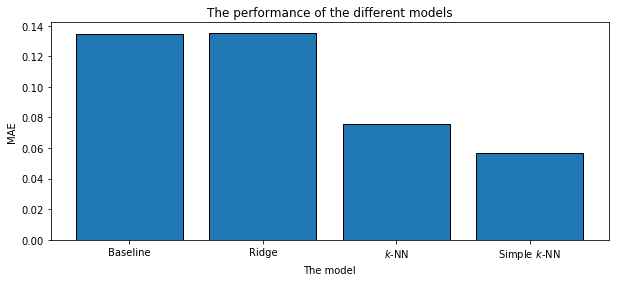

In [32]:
## Bar chart of the MAE
#######################
fig,axes=plt.subplots(1,1,figsize=(10,4))
plt.bar([1,2,3,4],[mae_baseline,mae_ridge,mae_knn_1,mae_knn_simple],
        edgecolor='black')
plt.xticks([1,2,3,4],['Baseline','Ridge','$k$-NN','Simple $k$-NN'])
plt.xlabel('The model')
plt.ylabel('MAE')
plt.title('The performance of the different models')
plt.show()

To conclude our analysis of the regression part, we wish to visualize the predictions of the different models and try to see where it fails to be accurate. We can focus on the period $2001-2013$ and take the annual mean variation, i.e. we average over the months.

In [33]:
## Filter 2001-2013
df_2000 = df[df.Year==2001].copy()

#####################
## k-NN prediction ##
#####################

## The columns to use
col_to_use = ['Latitude', 'Longitude', 'Month', 'Year',
            'log(Distance to ocean)','log(cumul(CO2))','log(Altitude)',
              'CO2 small']
## The columns to apply polynomial transformation
poly_cols = ['Latitude', 'Longitude','Year','log(Distance to ocean)',
             'log(cumul(CO2))','log(Altitude)']
## Get the variables
X,_,y,_ = get_variables(df_2000,col_to_use=col_to_use,
    poly_cols=poly_cols,encoding_cols=encoding_cols,test_size=0,deg=2,
                                                      random_state=0)
## Fit the model and compute predictions
pipe_knn.fit(X,y)
y_pred_knn = pipe_knn.predict(X)

#######################
## Ridge predictions ##
#######################

pipe_ridge.fit(X,y)
y_pred_ridge = pipe_ridge.predict(X)

################################
## The simple k-NN prediction ##
################################

## The columns to use
col_to_use = ['Latitude', 'Longitude', 'Month', 'Year']
## The columns to apply polynomial transformation
poly_cols = ['Latitude', 'Longitude','Year']
## Get the variables
X,_,y,_ = get_variables(df_2000,col_to_use=col_to_use,
    poly_cols=poly_cols,encoding_cols=encoding_cols,test_size=0,deg=2,
                                          random_state=0)
## Fit the model and compute predictions
pipe_knn.fit(X,y)
y_pred_simple = pipe_knn.predict(X)

In [34]:
## Add to the df_2000
df_2000['$k$-NN Predictions']=y_pred_knn
df_2000['Simple $k$-NN Predictions']=y_pred_simple
df_2000['Ridge Predictions'] = y_pred_ridge

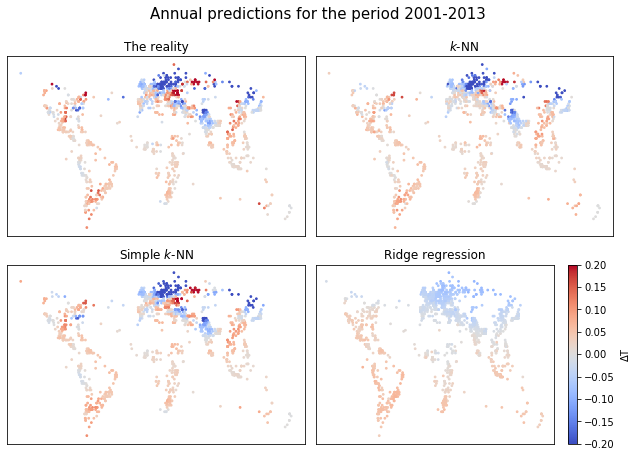

In [35]:
## Plot the different predictions
#################################
## Consider the annual mean
df_plot = df_2000.groupby('City').mean()

## The figure
fig,axes = plt.subplots(2,2,figsize=(9,6))
## The colorbar 
cm = plt.cm.get_cmap('coolwarm')

## The coordinates
x = df_plot['Longitude'].values
y = df_plot['Latitude'].values

## The temperatures
z = df_plot['$\Delta$T'].values # real
z_knn = df_plot['$k$-NN Predictions'].values # k-NN
z_simple = df_plot['Simple $k$-NN Predictions'].values # Simple k-NN
z_ridge = df_plot['Ridge Predictions'].values # Ridge 

## The different axes
## The reality
sc = axes[0,0].scatter(x, y,c=z, vmin=-0.2, vmax=0.2, s=3, cmap=cm)
axes[0,0].set_title('The reality')
axes[0,0].get_xaxis().set_visible(False)
axes[0,0].get_yaxis().set_visible(False)
## k-NN
sc = axes[0,1].scatter(x, y,c=z_knn, vmin=-0.2, vmax=0.2, s=3, cmap=cm)
axes[0,1].set_title('$k$-NN')
axes[0,1].get_xaxis().set_visible(False)
axes[0,1].get_yaxis().set_visible(False)
## Simple k-NN
sc = axes[1,0].scatter(x, y,c=z_simple, vmin=-0.2, vmax=0.2, s=3, cmap=cm)
axes[1,0].set_title('Simple $k$-NN')
axes[1,0].get_xaxis().set_visible(False)
axes[1,0].get_yaxis().set_visible(False)
## Ridge 
sc = axes[1,1].scatter(x, y,c=z_ridge, vmin=-0.2, vmax=0.2, s=3, cmap=cm)
axes[1,1].set_title('Ridge regression')
axes[1,1].get_xaxis().set_visible(False)
axes[1,1].get_yaxis().set_visible(False)
        
cbar = fig.colorbar(sc)
cbar.set_label('$\Delta$T')
plt.suptitle('Annual predictions for the period 2001-2013 ',
                                 fontsize=15).set_position([0.5,1.05])
plt.tight_layout()
plt.show()   

We are quite satisfied with the performance of the two $k$-NN models. Since the Ridge regression has the same performance than the baseline which predicts the median value, it is not very surprising that this model predicts kinds of uniform temperature variations. 

From this plot, it is not very easy to distinguish where the models make huge errors. In order to have a better idea, we can plot the curves of the difference (y-y_pred) against the latitude.

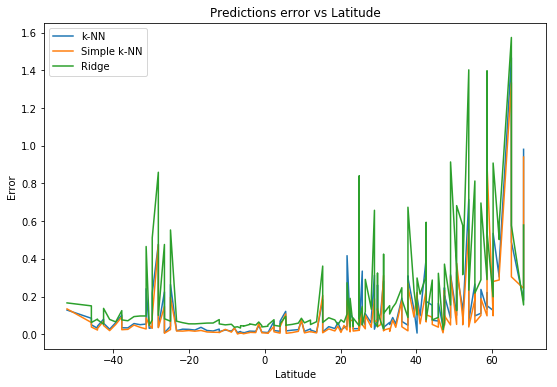

In [36]:
## Add error columns
####################
df_2000['k-NN Error']=np.abs(df_2000['$\Delta$T']-
                             df_2000['$k$-NN Predictions'])
df_2000['Simple k-NN Error']=np.abs(df_2000['$\Delta$T']-
                               df_2000['Simple $k$-NN Predictions'])
df_2000['Ridge Error'] = np.abs(df_2000['Ridge Predictions']-
                                df_2000['$\Delta$T'])
## Groupby Latitude
###################
df_plot = df_2000.groupby('Latitude').mean()

## Curves of the Errors
fig,axes = plt.subplots(1,1,figsize=(9,6))
plt.plot(df_plot.index.values,df_plot['k-NN Error'].values,label='k-NN')
plt.plot(df_plot.index.values,df_plot['Simple k-NN Error'].values,
         label='Simple k-NN')
plt.plot(df_plot.index.values,df_plot['Ridge Error'].values,label='Ridge')
plt.xlabel('Latitude')
plt.ylabel('Error')
plt.title('Predictions error vs Latitude')
plt.legend()
plt.show()

As expected, the errors are more important when we approach the poles. This plot is coherent with the distribution of $\Delta$T with respect to the Latitude variables; namely that the standard deviation increases with the latitude.

# The clustering part

In this last part, we will apply the $k$-mean algorithm to the data set data_kmean.csv. We recall that in this set, the rows correspond to the cities while the features are the coordinates and the annual temperatures variation. We are interested in the two following questions : do cities from the same part of the world appear in the same cluster ? Do the repartition of the clusters reflect how the cities are affected by the global warming.

In [37]:
## Download the csv file
df_kmean = pd.read_csv('data_kmean.csv')
## Print the top five entries
df_kmean.head()

,City,Latitude,Longitude,"(1744.0, 1.0)","(1744.0, 2.0)","(1744.0, 3.0)","(1744.0, 4.0)","(1744.0, 5.0)","(1744.0, 6.0)","(1744.0, 7.0)",...,"(2013.0, 3.0)","(2013.0, 4.0)","(2013.0, 5.0)","(2013.0, 6.0)","(2013.0, 7.0)","(2013.0, 8.0)","(2013.0, 9.0)","(2013.0, 10.0)","(2013.0, 11.0)","(2013.0, 12.0)"
0,A Coruña,42.59,-8.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.240,1.655,-2.435,-0.156,2.741,1.437,1.437,1.437,1.437,1.437
1,Aachen,50.63,6.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.326,0.374,-3.045,0.488,2.523,-0.861,-0.861,-0.861,-0.861,-0.861
2,Aalborg,57.05,10.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.524,-0.852,-0.044,1.894,1.513,0.417,0.417,0.417,0.417,0.417
3,Aba,5.63,8.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.382,-0.624,-0.026,-0.067,0.456,-0.432,-0.432,-0.432,-0.432,-0.432
4,Abadan,29.74,48.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.361,-1.233,-2.872,-1.113,-0.530,-1.422,-1.422,-1.422,-1.422,-1.422


In [38]:
## Set index = 'City'
df_kmean = df_kmean.set_index('City')

Because we want that the clusters only depend on the distribution of $\Delta$T, we may drop the coordinates columns when creating the $X$ variable.

In [39]:
## Create the X variable without the coordinates
X = df_kmean.drop(columns=['Longitude','Latitude'],axis=1).values

Since we have a lot of features in this DataFrame, it is very convenient here to use the `PCA` reduction and to choose the number of principal components such that $90$% of the variance is explained.

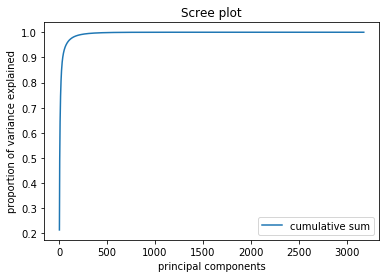

In [40]:
## PCA reduction
################
## Create the objects 
scaler = StandardScaler()
pca = PCA(n_components=None)
## Rescale and fit the PCA
X_rescaled = scaler.fit_transform(X)
pca.fit(X_rescaled)
## Scree plot of the pve
pve = pca.explained_variance_ratio_
xcor = np.arange(1,len(pve)+1) ## 1,2,...,n component
plt.plot(xcor, np.cumsum(pve),label='cumulative sum')
plt.xlabel('principal components')
plt.ylabel('proportion of variance explained')
plt.title('Scree plot')
plt.legend()
plt.show()

Of course this curve is asymptotic to $1$ but the important fact here is that it grows very fast and $90$% of the variance is explained by $36$ principal components.

In [41]:
## Compute the number of component to explain x% of the variance
def get_number_component(x): 
    if x<100:
        i=0
        while (np.cumsum(pve)[i]*100) < x:
            i+=1
        return(i+1)
    else:
        return 3180
## Print the result for x = 90
print('Number of principal components to explain 90% of the variance :{}'.format(
                                            get_number_component(90)))

Number of principal components to explain 90% of the variance :36


In [42]:
## Create the Kmean object as Pipeline
pipe_kmean = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=36,random_state=0)), # set the number of 
                                                 # components to 36
    ('kmean',KMeans(random_state=0))
])

Let's fit the $k$-mean algorithm for some clusters and plot them.

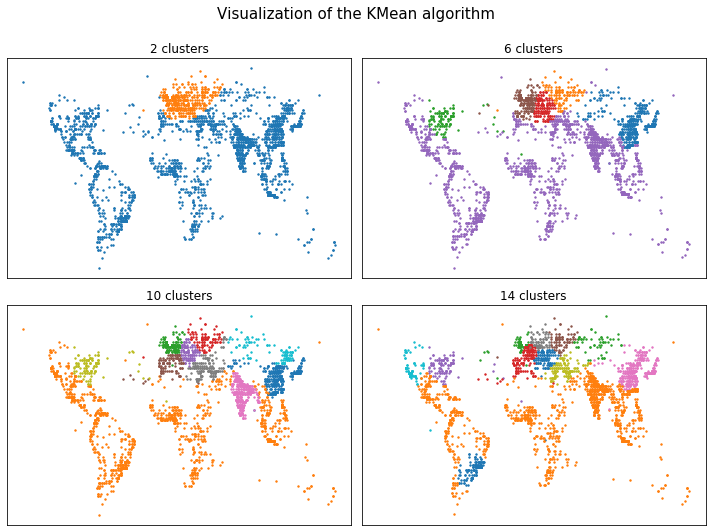

In [43]:
## Create the figure
fig,axes = plt.subplots(2,2,figsize=(10,7))
## Choose n_cluster = 2,6,10,14
for n_clusters,ax in zip(np.arange(2,15,4),axes.ravel()):
    ## Assign the number of clusters
    pipe_kmean.set_params(kmean__n_clusters=n_clusters)
    ## Fit the model and compute predictions
    pipe_kmean.fit(X,y=None)
    cluster_labels = pipe_kmean.predict(X)
    # Plot clusters
    for cluster in np.arange(n_clusters):
        # Get points in this cluster
        idx = (cluster_labels == cluster)
        # Plot points
        ax.scatter(
            df_kmean[idx].Longitude.values, df_kmean[idx].Latitude.values, 
            s=2, label='cluster {}'.format(cluster))
    ax.set_title('{} clusters'.format(n_clusters))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.suptitle('Visualization of the KMean algorithm',
            fontsize=15).set_position([0.5,1.05])
plt.show()

We are happy to see that the algorithm understands well the geographic coordinates altought it only has informations about temperature variations, for instance the clusters are not scattered everywhere on Earth. 

We remark that if we increase the number of clusters, then the clustering affects more the North hemisphere than the South; for  $n=14$, we only have $2$ clusters in the South hemisphere. This clearly reflects the complexity of the distribution of $\Delta$T in countries with high latitudes. 

we can now plot the distribution of $\Delta$T in each cluster for $n=6$ (the number of clusters). We just recall that this data set was built from the original one (without the extra features), so we may plot the different distributions using the full set.

In [44]:
## Download the full data set
df_full = pd.read_csv('data_ML.csv')

Let's visualize again the map for $n=6$ with the legend().

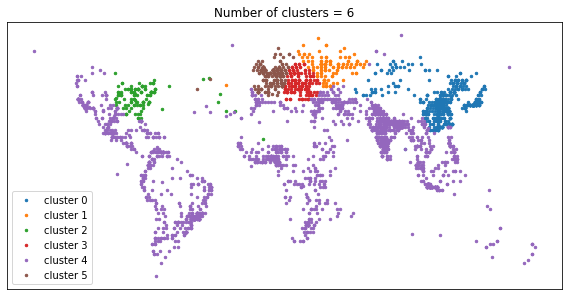

In [45]:
## Fix the number of clusters to 6
pipe_kmean.set_params(kmean__n_clusters=6)
## Fit and predict
pipe_kmean.fit(X,y=None)
clusters_label = pipe_kmean.predict(X)

fig,axes = plt.subplots(1,1,figsize=(8,4))
for cluster in np.arange(6):
    # Get points in this cluster
    idx = (clusters_label == cluster)
    # Plot points
    axes.scatter(
            df_kmean[idx].Longitude.values, df_kmean[idx].Latitude.values, 
            s=6, label='cluster {}'.format(cluster))
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
plt.legend()
plt.tight_layout()
plt.title('Number of clusters = 6')
plt.show()

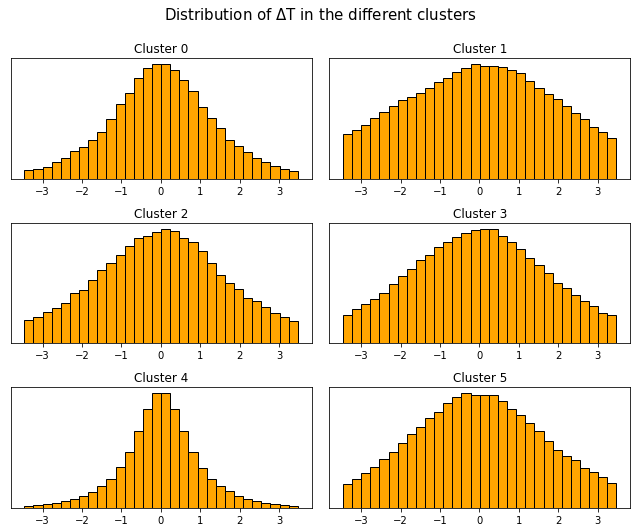

In [46]:
## Plot the distribution in each cluster
########################################
fig,axes = plt.subplots(3,2,figsize=(9,7))

for cluster,ax in zip(np.arange(6),axes.ravel()):
    idx = (clusters_label == cluster)
    ## The cities in this cluster
    cities = df_kmean[idx].index
    ## Filter the cities appearing in the above list
    filter_df = df_full[df_full.City.isin(cities)]
    ## plot the histogramm
    ax.hist(filter_df['$\Delta$T'].values,bins=30,edgecolor='black',
            color='orange')
    ax.set_title('Cluster {}'.format(cluster))
    ax.get_yaxis().set_visible(False)
plt.suptitle('Distribution of $\Delta$T in the different clusters',
            fontsize=15).set_position([0.5,1.05])
plt.tight_layout()
plt.show()

The above plots already look familiar to us (c.f. DataAnalysis.ipynb). The fourth distribution is very characteristic of the behavior of $\Delta$T in the South hemisphere; namely the values of $\Delta$T are very closed to the mean and extreme variations are rather rare. 

Its opposite is the Cluster number $1$ which brings together the countries of North-East Europe. In this region, the oscillation of $\Delta$T from one year to another and from a season to another is very important, which is illustrated by the wide shape of its distribution, i.e. a high standard deviation. 

The zero cluster, which reprensents the countries of East Asia seems to be an intermediate model between $1$ and $4$, something we also already observed in the previous Notebook. 

Finally, it is not obvious to distinguish only from the distribution what differentiates clusters $2,3$ and $5$. At least the standard deviation of $2$ (North-East America) seems to be smaller than the two others. 

The fact that the $k$-mean algorithm find different clusters principally in Europe is not very surprising. Indeed all scatter plots representing the cities with color intensity we analyzed until here clearly showed that $\Delta$T is not uniform in this region; some places are very red while others are very blue, but it is not chaotic in the sense that cities closed to each other share common $\Delta$T values.